In [1]:
from cd_v_partition.causal_discovery import ges_local_learn, damga_local_learn, pc_local_learn, rfci_local_learn
from cd_v_partition.utils import get_scores, get_confusion_matrix, shd
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Detecting 1 CUDA device(s).


## Observational Data

### Load Sachs dataset generated from scratch using the separate .csv files from the Sachs paper.
 Protein names are "praf", "pmek","plcg","PIP2","PIP3","p44/42","pakts473",  "PKA",  "PKC",  "P38", "pjnk"

In [2]:
df = pd.read_csv("sachs_raw.csv", sep=',',header=0)
df = df.rename(columns={"praf":1,  "pmek":2, "plcg":3,  "PIP2":4,  "PIP3":5,  "p44/42":6,  "pakts473":7,  "PKA":8,  "PKC":9,  "P38":10, "pjnk":11})
num_nodes = df.shape[1] - 1
df_obs = df.drop(df[df.target >0].index)
dag_edges = [["plcg", "PIP3"], ["PIP3", "PIP2"], ["plcg", "PIP2"], ["PKC", "P38"], ["PKC", "pmek"], ["PKC","pjnk"], ["PKC", "praf"], ["PKC", "PKA"],
             ["PKA", "P38"], ["PKA", "pjnk"], ["PKA", "pakts473"], ["PKA", "p44/42"], ["PKA", "pmek"], ["PKA", "praf"],
             ["praf","pmek"], ["pmek", "p44/42" ], ["p44/42","pakts473"]]
dag = nx.from_edgelist(dag_edges, create_using=nx.DiGraph)
dag =nx.adjacency_matrix(dag, nodelist=["praf",  "pmek", "plcg",  "PIP2",  "PIP3",  "p44/42",  "pakts473",  "PKA",  "PKC",  "P38", "pjnk"]).todense()

### Estimate DAGs using CD algs

In [3]:
est_dag_ges = ges_local_learn([np.ones((num_nodes, num_nodes)), df_obs], use_skel=False)
est_dag_dagma = damga_local_learn([np.ones((num_nodes, num_nodes)), df_obs], use_skel=False)
est_dag_pc = pc_local_learn([np.ones((num_nodes, num_nodes)), df_obs], use_skel=False)
est_dag_rfci = rfci_local_learn([np.ones((num_nodes, num_nodes)), df_obs], use_skel=False)

s = get_scores(['GES'], [est_dag_ges], dag)
print(get_confusion_matrix(est_dag_ges, dag))
s = get_scores(['DAGMA'], [est_dag_dagma], dag)
print(get_confusion_matrix(est_dag_dagma, dag))
s = get_scores(['PC'], [est_dag_ges], dag)
print(get_confusion_matrix(est_dag_pc, dag))
s = get_scores(['RFCI'], [est_dag_rfci], dag)
print(get_confusion_matrix(est_dag_rfci, dag))



  0%|          | 0/180000.0 [00:00<?, ?it/s]

{'tn': 97, 'fp': 11, 'fn': 7, 'tp': 6}
{'tn': 98, 'fp': 10, 'fn': 6, 'tp': 7}
{'tn': 93, 'fp': 8, 'fn': 11, 'tp': 9}
{'tn': 97, 'fp': 14, 'fn': 7, 'tp': 3}


In [4]:
def vis_graph(adj_mat, layout, ax):
    G = nx.from_numpy_array(adj_mat, create_using=nx.DiGraph)
    
    nx.draw(G, pos=layout, ax=ax, with_labels=True, node_size=100)

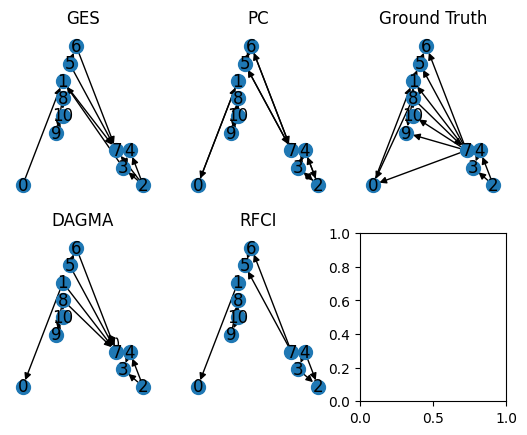

In [5]:
fig, axs = plt.subplots(2,3)
G_init = nx.from_numpy_array(dag, create_using=nx.DiGraph)
layout = nx.planar_layout(G_init)
vis_graph(est_dag_ges,layout,axs[0][0])
vis_graph(est_dag_dagma,layout,axs[1][0])
vis_graph(est_dag_pc,layout,axs[0][1])
vis_graph(est_dag_rfci,layout,axs[1][1])
vis_graph(dag,layout,axs[0][2])

axs[0][0].set_title("GES")
axs[1][0].set_title("DAGMA")
axs[0][1].set_title("PC")
axs[1][1].set_title("RFCI")
axs[0][2].set_title("Ground Truth")

plt.show()
df = df.rename(columns={"praf":1,  "pmek":2, "plcg":3,  "PIP2":4,  "PIP3":5,  "p44/42":6,  "pakts473":7,  "PKA":8,  "PKC":9,  "P38":10, "pjnk":11})

### Follow steps in bnlearn to estimate CPDAG from observational data using R
https://www.bnlearn.com/research/sachs05/

In [7]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
pcalg = importr("pcalg")
base = importr("base")
bnlearn = importr("bnlearn")
from rpy2.robjects import pandas2ri

In [8]:
data = df_obs.drop(columns=['target'])
with (ro.default_converter + pandas2ri.converter).context():
    dsachs = bnlearn.discretize(data, method = "hartemink",
            breaks = 3, ibreaks = 60, idisc = "quantile")

In [10]:
with (ro.default_converter + pandas2ri.converter).context():
    ro.r.assign("dsachs", dsachs)
    rcode = 'boot = boot.strength(dsachs, R = 500, algorithm = "hc", algorithm.args = list(score = "bde", iss = 10)) \n avg.boot = averaged.network(boot, threshold = 0.85) \n skeleton(avg.boot)'
    avg_boot = ro.r(rcode) 

In [11]:
flip=0
boot_r_source = []
boot_r_sink = []
for node in avg_boot['arcs']:
    if flip%2 == 0:
        boot_r_source.append(int(node)-1)
    else:
        boot_r_sink.append(int(node)-1)
    flip+=1
boot_r_edges = list(zip(boot_r_source, boot_r_sink))
dag_boot_r = nx.from_edgelist(boot_r_edges)
dag_boot_r = nx.adjacency_matrix(dag_boot_r, np.arange(11)).todense()

        

### Visualize R bootstrap CPDAG and DAGMA DAG compared to ground truth

Good news: DAGMA, which works on the raw continuous data (no bootstrap), estimates the same skeleton as R (bootstrap)

Text(0.5, 1.0, 'Ground Truth')

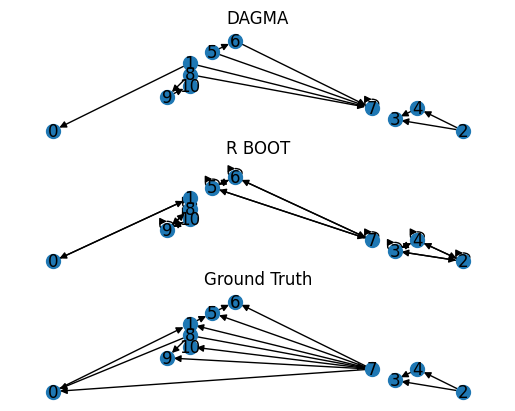

In [12]:
fig, axs = plt.subplots(3)
vis_graph(est_dag_dagma,layout,axs[0])
vis_graph(dag_boot_r,layout,axs[1])
vis_graph(dag,layout,axs[2])

axs[0].set_title("DAGMA")
axs[1].set_title("R BOOT")
axs[2].set_title("Ground Truth")

In [13]:
s = get_scores(['DAGMA'], [est_dag_dagma], dag)
print(get_confusion_matrix(est_dag_dagma, dag))
s = get_scores(['R BOOT'], [dag_boot_r], dag)
print(get_confusion_matrix(dag_boot_r, dag))

{'tn': 98, 'fp': 10, 'fn': 6, 'tp': 7}
{'tn': 84, 'fp': 8, 'fn': 20, 'tp': 9}


## Interventional Data

### Follow steps in bnlearn with interventional data using the pre discretized dataset sachs.interventional.txt

This completely recovers all the true postives (TP=17) 

In [21]:
with (ro.default_converter + pandas2ri.converter).context():
    rcode = 'sachs.modelstring <- paste("[PKC][PKA|PKC][Raf|PKC:PKA][Mek|PKC:PKA:Raf]","[Erk|Mek:PKA][Akt|Erk:PKA][P38|PKC:PKA]", "[Jnk|PKC:PKA][Plcg][PIP3|Plcg][PIP2|Plcg:PIP3]", sep = "")\n dag.sachs = model2network(sachs.modelstring)'
    model = ro.r(rcode)
    rcode = 'isachs = read.table("sachs.interventional.txt", header = TRUE, colClasses = "factor")\n INT = sapply(1:11, function(x) {which(isachs$INT == x) })\n nodes = names(isachs)[1:11]\n names(INT) = nodes\n start = random.graph(nodes = nodes, method = "melancon", num = 500, burn.in = 10^5, every = 100)\n netlist = lapply(start, function(net) { tabu(isachs[, 1:11], score = "mbde", exp = INT,iss = 1, start = net, tabu = 50)})\n intscore = custom.strength(netlist, nodes = nodes,cpdag = FALSE)'
    most_time_intensive_step = ro.r(rcode)
    rcode = 'averaged.network(intscore)'
    dag_r_int = ro.r(rcode)  

In [22]:
mapping = {"Raf":1,  "Mek":2, "Plcg":3,  "PIP2":4,  "PIP3":5,  "Erk":6,  "Akt":7,  "PKA":8,  "PKC":9,  "P38":10, "Jnk":11}
flip=0
boot_r_source = []
boot_r_sink = []
num_edges = len(dag_r_int['arcs'])/2
for node in dag_r_int['arcs']:
    if flip // num_edges == 0:
        boot_r_source.append(mapping[node])
    else:
       boot_r_sink.append(mapping[node])
    flip+=1
boot_r_edges = list(zip(boot_r_source, boot_r_sink))
int_dag_boot_r = nx.from_edgelist(boot_r_edges)
int_dag_boot_r = nx.adjacency_matrix(int_dag_boot_r, np.arange(1,12)).todense()

In [29]:
print(get_confusion_matrix(dag, int_dag_boot_r))
print(shd(dag, int_dag_boot_r))

{'tn': 71, 'fp': 33, 'fn': 0, 'tp': 17}
33


## Follow steps in bnlearn with interventional data but use sachs_raw dataset that I create and discretize

Strangely, these results do not agree with the results above. Which means whatever discretization used inn sachs.interventional.txt is different then for the observational data....this is annoyinng because it is not documented how this file was created

TP=12

In [24]:
# Looks like sachs.interventional.txt is discretized in a slightly different way
data = df.drop(columns=['target'])
with (ro.default_converter + pandas2ri.converter).context():
    isachs = bnlearn.discretize(data, method = "hartemink",
            breaks = 3, ibreaks = 60, idisc = "quantile")
    ro.r.assign("isachs", isachs)
    rcode = 'sachs.modelstring <- paste("[PKC][PKA|PKC][Raf|PKC:PKA][Mek|PKC:PKA:Raf]","[Erk|Mek:PKA][Akt|Erk:PKA][P38|PKC:PKA]", "[Jnk|PKC:PKA][Plcg][PIP3|Plcg][PIP2|Plcg:PIP3]", sep = "")\n dag.sachs = model2network(sachs.modelstring)'
    model = ro.r(rcode)
    rcode = 'INT = sapply(1:11, function(x) {which(isachs$INT == x) })\n nodes = names(isachs)[1:11]\n names(INT) = nodes\n start = random.graph(nodes = nodes, method = "melancon", num = 500, burn.in = 10^5, every = 100)\n netlist = lapply(start, function(net) { tabu(isachs[, 1:11], score = "mbde", exp = INT,iss = 1, start = net, tabu = 50)})\n intscore = custom.strength(netlist, nodes = nodes,cpdag = FALSE)'
    most_time_intensive_step = ro.r(rcode)
    rcode = 'averaged.network(intscore)'
    dag_r_int = ro.r(rcode) 

In [26]:
flip=0
boot_r_source = []
boot_r_sink = []
num_edges = len(dag_r_int['arcs'])/2
for node in dag_r_int['arcs']:
    if flip // num_edges == 0:
        boot_r_source.append(int(node))
    else:
       boot_r_sink.append(int(node))
    flip+=1
boot_r_edges = list(zip(boot_r_source, boot_r_sink))
my_int_dag_boot_r = nx.from_edgelist(boot_r_edges)
my_int_dag_boot_r = nx.adjacency_matrix(my_int_dag_boot_r, np.arange(1,12)).todense()

In [30]:
print(get_confusion_matrix(dag, my_int_dag_boot_r))
print(shd( dag, my_int_dag_boot_r))

{'tn': 74, 'fp': 30, 'fn': 5, 'tp': 12}
35


Text(0.5, 1.0, 'Ground Truth')

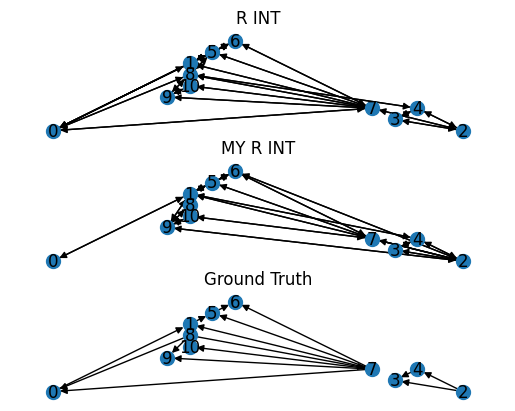

In [31]:
fig, axs = plt.subplots(3)
vis_graph(int_dag_boot_r,layout,axs[0])
vis_graph(my_int_dag_boot_r,layout,axs[1])
vis_graph(dag,layout,axs[2])

axs[0].set_title("R INT")
axs[1].set_title("MY R INT")
axs[2].set_title("Ground Truth")

### DAGMA and GIES with interventional data and no discretization

In [40]:
print(df)

          1      2      3       4      5      6      7       8      9    10  \
0      26.4  13.20   8.82   18.30  58.80   6.61   17.0   414.0  17.00  44.9   
1      35.9  16.50  12.30   16.80   8.13  18.60   32.5   352.0   3.37  16.5   
2      59.4  44.10  14.60   10.20  13.00  14.90   32.5   403.0  11.40  31.9   
3      73.0  82.80  23.10   13.50   1.29   5.83   11.8   528.0  13.70  28.6   
4      33.7  19.80   5.19    9.73  24.80  21.10   46.1   305.0   4.66  25.7   
...     ...    ...    ...     ...    ...    ...    ...     ...    ...   ...   
11782  14.9   9.56  21.30   29.70  16.10  67.30  113.0  1241.0  33.70  58.8   
11783  24.8  34.00  13.30   18.40   6.92  27.10   46.1   858.0  10.70  34.3   
11784  14.2  13.20  11.90  100.00   5.19  37.90   57.8   757.0  11.80  19.1   
11785  62.1  47.00  15.40   22.70   5.78  36.20   49.6   461.0  12.20  19.6   
11786  10.5   6.98  23.50   35.50   5.23  32.20   53.8   851.0  14.10  20.2   

          11  target  
0       40.0     0.0  
1    

In [38]:
est_dag_dagma_int = damga_local_learn([np.ones((num_nodes, num_nodes)), df], use_skel=False)
print(get_confusion_matrix(dag, est_dag_dagma_int))
print(shd( dag, est_dag_dagma_int))

  0%|          | 0/180000.0 [00:00<?, ?it/s]

{'tn': 96, 'fp': 8, 'fn': 11, 'tp': 6}
19


In [39]:
est_dag_gies_int = ges_local_learn([np.ones((num_nodes, num_nodes)), df], use_skel=False)
print(get_confusion_matrix(dag, est_dag_gies_int))
print(shd( dag, est_dag_gies_int))

RRuntimeError: Error in .tidyTargets(ncol(data), targets, target.index) : 
  Target index is out of range.
